In [1]:
import tensorflow as tf
from get_data import get_data

cifar_10 = get_data("cifar_10", "data/cifar_10/", augment_image=True, validation_size=1000)

Unpickling and reshaping data
Finished unpickling and reshaping data


In [2]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def batch_normalize(x, axes, depth):
    offset = tf.Variable(tf.zeros([depth]))
    scale = tf.Variable(tf.ones([depth]))
    
    moving_mean = tf.Variable(tf.zeros([depth]), trainable=False)
    moving_variance = tf.Variable(tf.zeros([depth]), trainable=False)
    
    def moving_values():
        return moving_mean, moving_variance
    
    def batch_values():
        batch_mean, batch_variance = tf.nn.moments(x, axes)
        assign_moving_mean = tf.assign(moving_mean, 0.01 * batch_mean + 0.99 * moving_mean)
        assign_moving_variance = tf.assign(moving_variance, 0.01 * batch_variance + 0.99 * moving_variance)
        with tf.control_dependencies([assign_moving_mean, assign_moving_variance]):
            batch_mean_copy = tf.identity(batch_mean)
            batch_variance_copy = tf.identity(batch_variance)
        return batch_mean_copy, batch_variance_copy
    
    mean, variance = tf.cond(test_time, moving_values, batch_values)
    
    return tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon=1e-5)

def conv_block(x, depth_in, depth_out):
    W_1 = weight_variable([1, 1, depth_in, depth_out / 2])
    W_2 = weight_variable([3, 3, depth_out / 2, depth_out / 2])
    W_3 = weight_variable([1, 1, depth_out / 2, depth_out])
    
    conv_1 = tf.nn.relu(batch_normalize(tf.nn.conv2d(x, W_1, strides=[1, 1, 1, 1], padding='SAME'), [0, 1, 2], depth_out / 2))
    conv_2 = tf.nn.relu(batch_normalize(tf.nn.conv2d(conv_1, W_2, strides=[1, 1, 1, 1], padding='SAME'), [0, 1, 2], depth_out / 2))
    conv_3 = tf.nn.relu(batch_normalize(tf.nn.conv2d(conv_2, W_3, strides=[1, 1, 1, 1], padding='SAME'), [0, 1, 2], depth_out))
    
    return conv_3

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def fc(x, W, depth, keep_prob):
    return tf.nn.dropout(tf.nn.relu(batch_normalize(tf.matmul(x, W), [0], depth)), keep_prob)

In [3]:
x = tf.placeholder(tf.float32, [None, 24, 24, 3])
keep_prob = tf.placeholder(tf.float32)
test_time = tf.placeholder(tf.bool)

conv_1 = conv_block(x, 3, 128)
conv_2 = conv_block(conv_1, 128, 128)
max_pool_2 = max_pool(conv_2)

conv_3 = conv_block(max_pool_2, 128, 256)
conv_4 = conv_block(conv_3, 256, 256)
max_pool_4 = max_pool(conv_4)

conv_5 = conv_block(max_pool_4, 256, 512)
conv_6 = conv_block(conv_5, 512, 512)
conv_7 = conv_block(conv_6, 512, 512)
max_pool_7 = max_pool(conv_7)

max_pool_7_flat = tf.reshape(max_pool_7, [-1, 4608])
max_pool_7_flat_dropout = tf.nn.dropout(max_pool_7_flat, keep_prob)

W_8 = weight_variable([4608, 1024])
fc_8 = fc(max_pool_7_flat_dropout, W_8, depth=1024, keep_prob=keep_prob)

W_9 = weight_variable([1024, 256])
fc_9 = fc(fc_8, W_9, depth=256, keep_prob=keep_prob)

W_10 = weight_variable([256, 10])
b_10 = tf.Variable(tf.zeros([10]))
y = tf.matmul(fc_9, W_10) + b_10

In [4]:
y_true = tf.placeholder(tf.float32, [None, 10])
reg_strength = tf.placeholder(tf.float32)

l2_loss = tf.nn.l2_loss(W_8) + tf.nn.l2_loss(W_9) + tf.nn.l2_loss(W_10)
model_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_true))

loss = model_loss + reg_strength * l2_loss

learning_rate = tf.Variable(5e-4, trainable=False)
lr_update = tf.assign(learning_rate, learning_rate / 10)

step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [5]:
sess = tf.Session()

In [6]:
percent_correct = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1)), tf.float32))

In [7]:
sess.run(tf.global_variables_initializer())

num_batches = 48001

losses = []
train_accs = []
val_accs = []

for i in range(num_batches):
    x_batch, y_batch = cifar_10.train.next_batch(64, crop_size=24)
    _, current_loss, lr = sess.run([step, loss, learning_rate], {x: x_batch, y_true: y_batch, keep_prob: 0.5, test_time: False, reg_strength: 0.008})
    losses.append(current_loss)
    if i % 500 == 0:
        train_x, train_y = cifar_10.train.next_batch(500, crop_size=24, test_time=True)
        train_accs.append(sess.run(percent_correct, feed_dict={x: train_x, y_true: train_y, keep_prob: 1, test_time: True}))
        
        val_x, val_y = cifar_10.validation.next_batch(500, crop_size=24, test_time=True)
        val_accs.append(sess.run(percent_correct, feed_dict={x: val_x, y_true: val_y, keep_prob: 1, test_time: True}))
        
    if i % 3000 == 0:
        print 'loss at step {} w/ lr {:.1e}: {}'.format(i, lr, losses[-1])
        print 'training accuracy at step {}: {:.3f}'.format(i, train_accs[-1])
        print 'validation accuracy at step {}: {:.3f}'.format(i, val_accs[-1])
        print ''
        
    if i == 36000:
        sess.run(lr_update)

loss at step 0 w/ lr 5.0e-04: 157.14050293
training accuracy at step 0: 0.122
validation accuracy at step 0: 0.106

loss at step 3000 w/ lr 5.0e-04: 1.51450800896
training accuracy at step 3000: 0.548
validation accuracy at step 3000: 0.614

loss at step 6000 w/ lr 5.0e-04: 1.0689252615
training accuracy at step 6000: 0.684
validation accuracy at step 6000: 0.656

loss at step 9000 w/ lr 5.0e-04: 1.02840936184
training accuracy at step 9000: 0.786
validation accuracy at step 9000: 0.788

loss at step 12000 w/ lr 5.0e-04: 1.22702693939
training accuracy at step 12000: 0.794
validation accuracy at step 12000: 0.784

loss at step 15000 w/ lr 5.0e-04: 0.759241998196
training accuracy at step 15000: 0.810
validation accuracy at step 15000: 0.814

loss at step 18000 w/ lr 5.0e-04: 0.897723913193
training accuracy at step 18000: 0.844
validation accuracy at step 18000: 0.820

loss at step 21000 w/ lr 5.0e-04: 0.602716207504
training accuracy at step 21000: 0.900
validation accuracy at step 21

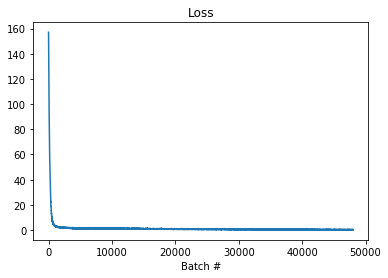

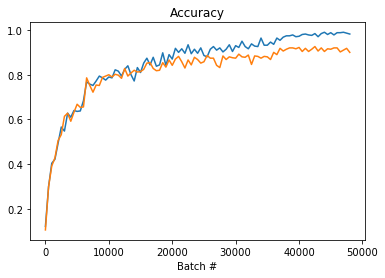

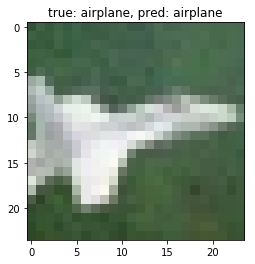

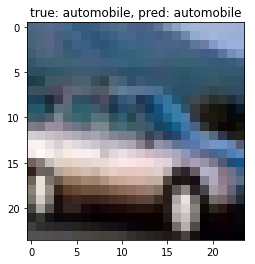

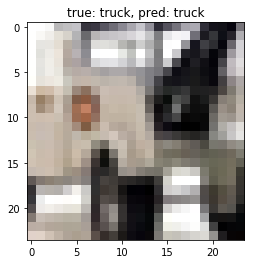

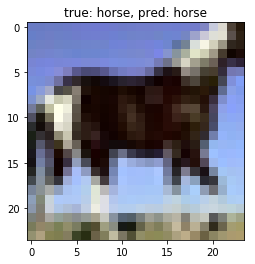

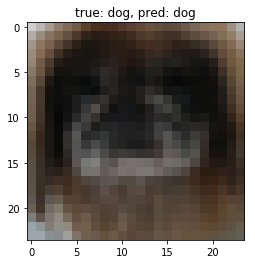

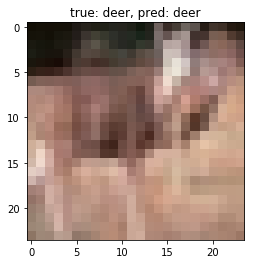

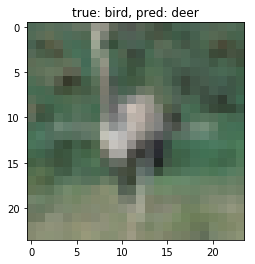

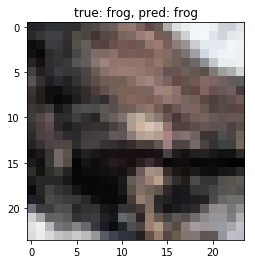

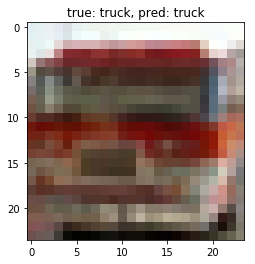

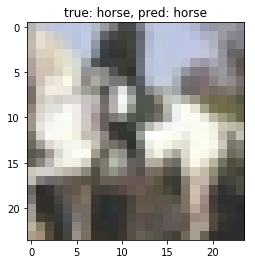

In [8]:
import visualizations

visualizations.plot_learning_curve([losses])
visualizations.plot_learning_curve([train_accs, val_accs], x_axis=range(0, num_batches, 500), title='Accuracy')

sample_data, sample_labels = cifar_10.validation.next_batch(10, crop_size=24, test_time=True)
y_pred = sess.run(y, feed_dict={x: sample_data, y_true: sample_labels, keep_prob: 1, test_time: True})

visualizations.show_images('cifar_10', sample_data, sample_labels, y_pred)

In [9]:
def get_test_avg():
    test_avgs = []

    cifar_10.test.reset()

    for _ in range(10):
        test_x, test_y = cifar_10.test.next_batch(1000, crop_size=24, test_time=True)
        test_avgs.append(sess.run(percent_correct, feed_dict={x: test_x, y_true: test_y, keep_prob: 1, test_time: True}))

    return sum(test_avgs) / 10

def get_train_avg():
    test_avgs = []
    for _ in range(10):
        test_x, test_y = cifar_10.train.next_batch(1000, crop_size=24, test_time=True)
        test_avgs.append(sess.run(percent_correct, feed_dict={x: test_x, y_true: test_y, keep_prob: 1, test_time: True}))

    return sum(test_avgs) / 10

In [10]:
print get_test_avg()

0.912900048494


In [11]:
print get_train_avg()

0.981799972057


In [12]:
sess.close()